In [1]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from convNetUtils import cross_validation, evaluate_model
from visualizationUtils import label_first_detections, plot_confusion_matrix
from bandUtils import Band
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
NB_TESTS = 4
NB_PIXEL_AROUND = 4
EPOCHS = 2000
LABELS_COORDINATES = vietnam_labels_coordinates()

In [3]:
# Without :
# Label.INTERCROP,
# Label.STICK_FOR_PEPPER,   
# Label.PEPPER_AND_COFFEE,     
# Label.PEPPER_AND_OTHER
# Label.SPARE_TREE,     


bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [4]:
model_name = "january_to_april_2018_every_usable_labels"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(0.0000275, offset=0.2, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

351/351 [==============================] - 1s 3ms/step - loss: 1.1152 - accuracy: 0.5029 - val_loss: 1.4864 - val_accuracy: 0.4959
Epoch 41/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2542 - accuracy: 0.4742 - val_loss: 1.3668 - val_accuracy: 0.5339
Epoch 42/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2146 - accuracy: 0.4766 - val_loss: 1.5816 - val_accuracy: 0.4519
Epoch 43/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1539 - accuracy: 0.4958 - val_loss: 1.3101 - val_accuracy: 0.5385
Epoch 44/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0868 - accuracy: 0.5078 - val_loss: 1.3214 - val_accuracy: 0.5492
Epoch 45/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3625 - accuracy: 0.4809 - val_loss: 1.4926 - val_accuracy: 0.4675
Epoch 46/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1459 - accuracy: 0.4936 - val_loss: 1.4206 - val_accuracy: 0.5385

351/351 [==============================] - 1s 4ms/step - loss: 0.9575 - accuracy: 0.5552 - val_loss: 1.1508 - val_accuracy: 0.6146
Epoch 97/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9232 - accuracy: 0.5623 - val_loss: 1.2222 - val_accuracy: 0.5922
Epoch 98/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1993 - accuracy: 0.5353 - val_loss: 1.2361 - val_accuracy: 0.5861
Epoch 99/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0263 - accuracy: 0.5407 - val_loss: 1.1945 - val_accuracy: 0.5872
Epoch 100/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1593 - accuracy: 0.5272 - val_loss: 1.1491 - val_accuracy: 0.6014
Epoch 101/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2430 - accuracy: 0.5449 - val_loss: 1.2996 - val_accuracy: 0.5641
Epoch 102/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0707 - accuracy: 0.5685 - val_loss: 1.1206 - val_accuracy: 0.6

351/351 [==============================] - 1s 4ms/step - loss: 0.8627 - accuracy: 0.5837 - val_loss: 1.1336 - val_accuracy: 0.6238
Epoch 153/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8175 - accuracy: 0.5919 - val_loss: 1.0394 - val_accuracy: 0.6565
Epoch 154/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9247 - accuracy: 0.5812 - val_loss: 1.1982 - val_accuracy: 0.5964
Epoch 155/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9731 - accuracy: 0.5696 - val_loss: 1.0596 - val_accuracy: 0.6515
Epoch 156/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8617 - accuracy: 0.5881 - val_loss: 1.1042 - val_accuracy: 0.6306
Epoch 157/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9768 - accuracy: 0.5773 - val_loss: 1.7400 - val_accuracy: 0.4810
Epoch 158/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1684 - accuracy: 0.5266 - val_loss: 1.1209 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0222 - accuracy: 0.5488 - val_loss: 1.2473 - val_accuracy: 0.5854
Epoch 209/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8905 - accuracy: 0.5784 - val_loss: 1.0904 - val_accuracy: 0.6355
Epoch 210/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7717 - accuracy: 0.6093 - val_loss: 1.1210 - val_accuracy: 0.6337
Epoch 211/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9321 - accuracy: 0.5580 - val_loss: 1.3844 - val_accuracy: 0.5442
Epoch 212/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9591 - accuracy: 0.5728 - val_loss: 1.1549 - val_accuracy: 0.6178
Epoch 213/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7878 - accuracy: 0.6093 - val_loss: 1.0002 - val_accuracy: 0.6771
Epoch 214/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8977 - accuracy: 0.5906 - val_loss: 1.1262 - val_accuracy: 

Epoch 11/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.6773 - accuracy: 0.3552 - val_loss: 1.7654 - val_accuracy: 0.4181
Epoch 12/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.6988 - accuracy: 0.3509 - val_loss: 1.8016 - val_accuracy: 0.3822
Epoch 13/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5261 - accuracy: 0.3842 - val_loss: 1.6640 - val_accuracy: 0.4171
Epoch 14/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4433 - accuracy: 0.3968 - val_loss: 1.5749 - val_accuracy: 0.4433
Epoch 15/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4270 - accuracy: 0.3982 - val_loss: 1.9012 - val_accuracy: 0.3787
Epoch 16/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4559 - accuracy: 0.4034 - val_loss: 1.7843 - val_accuracy: 0.3957
Epoch 17/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5338 - accuracy: 0.4094 - val_loss: 1.7331 - val_ac

351/351 [==============================] - 1s 4ms/step - loss: 1.0639 - accuracy: 0.5308 - val_loss: 1.2538 - val_accuracy: 0.5712
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1231 - accuracy: 0.5403 - val_loss: 1.2796 - val_accuracy: 0.5663
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9451 - accuracy: 0.5608 - val_loss: 1.2086 - val_accuracy: 0.5808
Epoch 70/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9151 - accuracy: 0.5712 - val_loss: 1.1676 - val_accuracy: 0.6099
Epoch 71/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9380 - accuracy: 0.5559 - val_loss: 1.2685 - val_accuracy: 0.5606
Epoch 72/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9853 - accuracy: 0.5504 - val_loss: 1.2325 - val_accuracy: 0.5869
Epoch 73/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0474 - accuracy: 0.5369 - val_loss: 1.3241 - val_accuracy: 0.5563

351/351 [==============================] - 1s 3ms/step - loss: 1.0113 - accuracy: 0.5535 - val_loss: 1.2384 - val_accuracy: 0.5773
Epoch 124/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8461 - accuracy: 0.5782 - val_loss: 1.1001 - val_accuracy: 0.6266
Epoch 125/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9657 - accuracy: 0.5560 - val_loss: 1.1458 - val_accuracy: 0.6121
Epoch 126/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8635 - accuracy: 0.5835 - val_loss: 1.2059 - val_accuracy: 0.5918
Epoch 127/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9141 - accuracy: 0.5793 - val_loss: 1.1879 - val_accuracy: 0.5904
Epoch 128/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8418 - accuracy: 0.5836 - val_loss: 1.1901 - val_accuracy: 0.5975
Epoch 129/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8317 - accuracy: 0.5846 - val_loss: 1.2038 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8410 - accuracy: 0.5900 - val_loss: 1.1477 - val_accuracy: 0.6060
Epoch 180/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8791 - accuracy: 0.5785 - val_loss: 1.2206 - val_accuracy: 0.6071
Epoch 181/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8698 - accuracy: 0.5790 - val_loss: 1.1308 - val_accuracy: 0.6185
Epoch 182/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9161 - accuracy: 0.5925 - val_loss: 1.1489 - val_accuracy: 0.6181
Epoch 183/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8254 - accuracy: 0.5910 - val_loss: 1.1386 - val_accuracy: 0.6046
Epoch 184/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8183 - accuracy: 0.5858 - val_loss: 1.1738 - val_accuracy: 0.6039
Epoch 185/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8769 - accuracy: 0.5942 - val_loss: 1.0881 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8746 - accuracy: 0.5813 - val_loss: 1.0771 - val_accuracy: 0.6298
Epoch 236/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5285 - accuracy: 0.4750 - val_loss: 1.3262 - val_accuracy: 0.5613
Epoch 237/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2556 - accuracy: 0.5221 - val_loss: 1.4049 - val_accuracy: 0.5218
Epoch 238/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0161 - accuracy: 0.5522 - val_loss: 1.1681 - val_accuracy: 0.6096
Epoch 239/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2067 - accuracy: 0.5452 - val_loss: 1.1748 - val_accuracy: 0.6078
Epoch 240/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8721 - accuracy: 0.5832 - val_loss: 1.1290 - val_accuracy: 0.6316
Epoch 241/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8946 - accuracy: 0.6016 - val_loss: 1.1862 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.9907 - accuracy: 0.5813 - val_loss: 1.4469 - val_accuracy: 0.5456
Epoch 292/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9936 - accuracy: 0.5583 - val_loss: 1.1758 - val_accuracy: 0.6192
Epoch 293/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8987 - accuracy: 0.5758 - val_loss: 1.4071 - val_accuracy: 0.5233
Epoch 294/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8013 - accuracy: 0.5991 - val_loss: 1.1248 - val_accuracy: 0.6281
Epoch 295/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7820 - accuracy: 0.6058 - val_loss: 1.1486 - val_accuracy: 0.6281
Epoch 296/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8391 - accuracy: 0.5972 - val_loss: 1.4214 - val_accuracy: 0.5144
Epoch 297/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8927 - accuracy: 0.5770 - val_loss: 1.0494 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1539 - accuracy: 0.5018 - val_loss: 1.3447 - val_accuracy: 0.5414
Epoch 348/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4203 - accuracy: 0.5136 - val_loss: 1.5964 - val_accuracy: 0.4845
Epoch 349/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4260 - accuracy: 0.5161 - val_loss: 1.5788 - val_accuracy: 0.4913
Epoch 350/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0387 - accuracy: 0.5290 - val_loss: 1.3516 - val_accuracy: 0.5453
Epoch 351/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4223 - accuracy: 0.5299 - val_loss: 1.3647 - val_accuracy: 0.5488
Epoch 352/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0902 - accuracy: 0.5411 - val_loss: 1.3122 - val_accuracy: 0.5751
Epoch 353/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2335 - accuracy: 0.5329 - val_loss: 1.4555 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.6096 - accuracy: 0.3955 - val_loss: 1.7602 - val_accuracy: 0.3982
Epoch 19/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.6104 - accuracy: 0.3946 - val_loss: 1.4890 - val_accuracy: 0.5076
Epoch 20/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5330 - accuracy: 0.4153 - val_loss: 1.7207 - val_accuracy: 0.4135
Epoch 21/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5635 - accuracy: 0.3972 - val_loss: 1.5720 - val_accuracy: 0.4497
Epoch 22/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4649 - accuracy: 0.4142 - val_loss: 1.5170 - val_accuracy: 0.4760
Epoch 23/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4137 - accuracy: 0.4337 - val_loss: 1.5257 - val_accuracy: 0.4877
Epoch 24/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4212 - accuracy: 0.4470 - val_loss: 1.9085 - val_accuracy: 0.4782

351/351 [==============================] - 1s 3ms/step - loss: 0.9384 - accuracy: 0.5512 - val_loss: 1.1622 - val_accuracy: 0.6163
Epoch 75/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9110 - accuracy: 0.5695 - val_loss: 1.1424 - val_accuracy: 0.6178
Epoch 76/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0607 - accuracy: 0.5388 - val_loss: 1.2541 - val_accuracy: 0.5741
Epoch 77/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2790 - accuracy: 0.5121 - val_loss: 1.2357 - val_accuracy: 0.5790
Epoch 78/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1164 - accuracy: 0.5275 - val_loss: 1.2435 - val_accuracy: 0.5826
Epoch 79/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0515 - accuracy: 0.5385 - val_loss: 1.2094 - val_accuracy: 0.5798
Epoch 80/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9907 - accuracy: 0.5413 - val_loss: 1.3218 - val_accuracy: 0.5481

351/351 [==============================] - 1s 3ms/step - loss: 1.0383 - accuracy: 0.5584 - val_loss: 1.1126 - val_accuracy: 0.6288
Epoch 131/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9436 - accuracy: 0.5685 - val_loss: 1.1611 - val_accuracy: 0.6032
Epoch 132/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9056 - accuracy: 0.5837 - val_loss: 1.0525 - val_accuracy: 0.6398
Epoch 133/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9241 - accuracy: 0.5844 - val_loss: 1.1818 - val_accuracy: 0.6014
Epoch 134/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9577 - accuracy: 0.5576 - val_loss: 1.2410 - val_accuracy: 0.5652
Epoch 135/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1067 - accuracy: 0.5294 - val_loss: 1.2520 - val_accuracy: 0.5748
Epoch 136/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9497 - accuracy: 0.5516 - val_loss: 1.0663 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0006 - accuracy: 0.5890 - val_loss: 1.1083 - val_accuracy: 0.6259
Epoch 187/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9068 - accuracy: 0.5928 - val_loss: 1.0201 - val_accuracy: 0.6565
Epoch 188/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9611 - accuracy: 0.5834 - val_loss: 1.1011 - val_accuracy: 0.6277
Epoch 189/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8752 - accuracy: 0.5869 - val_loss: 1.1037 - val_accuracy: 0.6266
Epoch 190/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8846 - accuracy: 0.5861 - val_loss: 1.1401 - val_accuracy: 0.6174
Epoch 191/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9326 - accuracy: 0.5644 - val_loss: 1.0321 - val_accuracy: 0.6494
Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8053 - accuracy: 0.6072 - val_loss: 1.0298 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8514 - accuracy: 0.6030 - val_loss: 1.0666 - val_accuracy: 0.6330
Epoch 243/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9286 - accuracy: 0.5854 - val_loss: 1.3370 - val_accuracy: 0.5609
Epoch 244/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.8473 - accuracy: 0.5036 - val_loss: 1.1952 - val_accuracy: 0.6053
Epoch 245/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9416 - accuracy: 0.5638 - val_loss: 1.0629 - val_accuracy: 0.6384
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9211 - accuracy: 0.5788 - val_loss: 1.1827 - val_accuracy: 0.6011
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9153 - accuracy: 0.5895 - val_loss: 1.6052 - val_accuracy: 0.5194
Epoch 248/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8960 - accuracy: 0.5867 - val_loss: 1.0414 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8217 - accuracy: 0.6193 - val_loss: 0.9345 - val_accuracy: 0.6792
Epoch 299/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0248 - accuracy: 0.5705 - val_loss: 1.0309 - val_accuracy: 0.6561
Epoch 300/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9260 - accuracy: 0.5856 - val_loss: 1.1745 - val_accuracy: 0.5996
Epoch 301/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8123 - accuracy: 0.5988 - val_loss: 1.0006 - val_accuracy: 0.6632
Epoch 302/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1055 - accuracy: 0.5765 - val_loss: 1.0402 - val_accuracy: 0.6583
Epoch 303/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9677 - accuracy: 0.5750 - val_loss: 1.0430 - val_accuracy: 0.6565
Epoch 304/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9379 - accuracy: 0.5959 - val_loss: 1.1877 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.9587 - accuracy: 0.5742 - val_loss: 1.1717 - val_accuracy: 0.6053
Epoch 355/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.9892 - accuracy: 0.5000 - val_loss: 1.6942 - val_accuracy: 0.4178
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.6966 - accuracy: 0.3991 - val_loss: 1.4463 - val_accuracy: 0.4945
Epoch 357/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1818 - accuracy: 0.5089 - val_loss: 1.1563 - val_accuracy: 0.6075
Epoch 358/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9277 - accuracy: 0.5602 - val_loss: 1.1246 - val_accuracy: 0.6146
Epoch 359/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9494 - accuracy: 0.5731 - val_loss: 1.0375 - val_accuracy: 0.6497
Epoch 360/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8854 - accuracy: 0.6003 - val_loss: 0.9921 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 3.1829 - accuracy: 0.4756 - val_loss: 1.2698 - val_accuracy: 0.6000
Epoch 411/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.1014 - accuracy: 0.5402 - val_loss: 1.4909 - val_accuracy: 0.5293
Epoch 412/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5598 - accuracy: 0.5027 - val_loss: 1.2720 - val_accuracy: 0.5773
Epoch 413/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4023 - accuracy: 0.5344 - val_loss: 1.1712 - val_accuracy: 0.6135
Epoch 414/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0042 - accuracy: 0.5811 - val_loss: 1.0445 - val_accuracy: 0.6657
Epoch 415/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2176 - accuracy: 0.5560 - val_loss: 1.1179 - val_accuracy: 0.6373
Epoch 416/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9563 - accuracy: 0.5838 - val_loss: 1.0764 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8096 - accuracy: 0.6172 - val_loss: 0.9857 - val_accuracy: 0.6572
Epoch 467/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8089 - accuracy: 0.6218 - val_loss: 1.0628 - val_accuracy: 0.6302
Epoch 468/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9505 - accuracy: 0.5851 - val_loss: 1.3126 - val_accuracy: 0.5741
Epoch 469/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9284 - accuracy: 0.5777 - val_loss: 1.0192 - val_accuracy: 0.6593
Epoch 470/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1127 - accuracy: 0.5543 - val_loss: 1.2113 - val_accuracy: 0.5933
Epoch 471/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9548 - accuracy: 0.6002 - val_loss: 0.9781 - val_accuracy: 0.6714
Epoch 472/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8640 - accuracy: 0.6046 - val_loss: 1.2153 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.4779 - accuracy: 0.4220 - val_loss: 1.9716 - val_accuracy: 0.3165
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5346 - accuracy: 0.4100 - val_loss: 1.4882 - val_accuracy: 0.5254
Epoch 21/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4167 - accuracy: 0.4258 - val_loss: 1.7285 - val_accuracy: 0.4185
Epoch 22/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5173 - accuracy: 0.4337 - val_loss: 1.5567 - val_accuracy: 0.5044
Epoch 23/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.7392 - accuracy: 0.4143 - val_loss: 1.4935 - val_accuracy: 0.5030
Epoch 24/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5184 - accuracy: 0.4264 - val_loss: 1.5514 - val_accuracy: 0.4899
Epoch 25/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5815 - accuracy: 0.4234 - val_loss: 1.9148 - val_accuracy: 0.3758

351/351 [==============================] - 1s 3ms/step - loss: 1.2386 - accuracy: 0.4961 - val_loss: 1.4679 - val_accuracy: 0.5286
Epoch 76/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1014 - accuracy: 0.5274 - val_loss: 1.2630 - val_accuracy: 0.5890
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1786 - accuracy: 0.5120 - val_loss: 1.3173 - val_accuracy: 0.5734
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1252 - accuracy: 0.5210 - val_loss: 1.3664 - val_accuracy: 0.5474
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0304 - accuracy: 0.5297 - val_loss: 1.2081 - val_accuracy: 0.6011
Epoch 80/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1184 - accuracy: 0.5302 - val_loss: 1.3382 - val_accuracy: 0.5570
Epoch 81/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0171 - accuracy: 0.5465 - val_loss: 1.2262 - val_accuracy: 0.5929

351/351 [==============================] - 1s 4ms/step - loss: 0.9234 - accuracy: 0.5736 - val_loss: 1.2385 - val_accuracy: 0.6188
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0472 - accuracy: 0.5548 - val_loss: 1.2002 - val_accuracy: 0.6067
Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8689 - accuracy: 0.5818 - val_loss: 1.1788 - val_accuracy: 0.6092
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8658 - accuracy: 0.5880 - val_loss: 1.1021 - val_accuracy: 0.6455
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2280 - accuracy: 0.5020 - val_loss: 1.2941 - val_accuracy: 0.5794
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1632 - accuracy: 0.5244 - val_loss: 1.2551 - val_accuracy: 0.5780
Epoch 137/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5661 - accuracy: 0.5188 - val_loss: 1.3354 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8289 - accuracy: 0.5896 - val_loss: 1.1534 - val_accuracy: 0.6302
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9253 - accuracy: 0.5860 - val_loss: 1.1942 - val_accuracy: 0.6128
Epoch 189/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9608 - accuracy: 0.5626 - val_loss: 1.1134 - val_accuracy: 0.6277
Epoch 190/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9619 - accuracy: 0.5924 - val_loss: 1.1968 - val_accuracy: 0.6096
Epoch 191/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1310 - accuracy: 0.5541 - val_loss: 1.2152 - val_accuracy: 0.6028
Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9956 - accuracy: 0.5564 - val_loss: 1.3057 - val_accuracy: 0.5343
Epoch 193/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1891 - accuracy: 0.5384 - val_loss: 1.3047 - val_accuracy: 

351/351 [==============================] - 2s 5ms/step - loss: 1.4196 - accuracy: 0.5537 - val_loss: 1.3441 - val_accuracy: 0.5709
Epoch 244/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.8789 - accuracy: 0.5850 - val_loss: 1.1331 - val_accuracy: 0.6238
Epoch 245/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.0052 - accuracy: 0.5750 - val_loss: 1.1589 - val_accuracy: 0.6217
Epoch 246/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.9262 - accuracy: 0.5877 - val_loss: 1.1126 - val_accuracy: 0.6472
Epoch 247/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.1986 - accuracy: 0.5530 - val_loss: 1.2039 - val_accuracy: 0.6139
Epoch 248/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.9520 - accuracy: 0.5874 - val_loss: 1.1493 - val_accuracy: 0.6369
Epoch 249/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.8420 - accuracy: 0.6040 - val_loss: 1.1198 - val_accuracy: 

351/351 [==============================] - 2s 5ms/step - loss: 1.3874 - accuracy: 0.4187 - val_loss: 1.6002 - val_accuracy: 0.4249
Epoch 29/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.4010 - accuracy: 0.4253 - val_loss: 1.5114 - val_accuracy: 0.4817
Epoch 30/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.4100 - accuracy: 0.4324 - val_loss: 1.9507 - val_accuracy: 0.3343
Epoch 31/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.4515 - accuracy: 0.4300 - val_loss: 1.6206 - val_accuracy: 0.4263
Epoch 32/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.3879 - accuracy: 0.4386 - val_loss: 1.6681 - val_accuracy: 0.4568
Epoch 33/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.3979 - accuracy: 0.4385 - val_loss: 1.5902 - val_accuracy: 0.4746
Epoch 34/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.2415 - accuracy: 0.4689 - val_loss: 1.4369 - val_accuracy: 0.5087

351/351 [==============================] - 2s 5ms/step - loss: 1.1476 - accuracy: 0.5321 - val_loss: 1.3118 - val_accuracy: 0.5663
Epoch 85/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.2934 - accuracy: 0.5160 - val_loss: 1.2687 - val_accuracy: 0.5805
Epoch 86/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.9553 - accuracy: 0.5520 - val_loss: 1.2567 - val_accuracy: 0.5883
Epoch 87/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.0306 - accuracy: 0.5526 - val_loss: 1.2436 - val_accuracy: 0.5940
Epoch 88/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.9895 - accuracy: 0.5560 - val_loss: 1.2490 - val_accuracy: 0.5993
Epoch 89/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.9613 - accuracy: 0.5586 - val_loss: 1.4306 - val_accuracy: 0.5286
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0940 - accuracy: 0.5348 - val_loss: 1.1927 - val_accuracy: 0.6082

351/351 [==============================] - 1s 4ms/step - loss: 0.9826 - accuracy: 0.5657 - val_loss: 1.3071 - val_accuracy: 0.5591
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0016 - accuracy: 0.5547 - val_loss: 1.1867 - val_accuracy: 0.6075
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9565 - accuracy: 0.5649 - val_loss: 1.3286 - val_accuracy: 0.5425
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9428 - accuracy: 0.5576 - val_loss: 1.5814 - val_accuracy: 0.4632
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0542 - accuracy: 0.5239 - val_loss: 1.1513 - val_accuracy: 0.6124
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9772 - accuracy: 0.5641 - val_loss: 1.3432 - val_accuracy: 0.5488
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9761 - accuracy: 0.5581 - val_loss: 1.2500 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.3601 - accuracy: 0.4406 - val_loss: 1.5746 - val_accuracy: 0.4625
Epoch 22/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4473 - accuracy: 0.4383 - val_loss: 1.6968 - val_accuracy: 0.4057
Epoch 23/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3522 - accuracy: 0.4439 - val_loss: 1.5649 - val_accuracy: 0.4572
Epoch 24/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3437 - accuracy: 0.4443 - val_loss: 1.5381 - val_accuracy: 0.4650
Epoch 25/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3018 - accuracy: 0.4522 - val_loss: 1.4992 - val_accuracy: 0.4767
Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3486 - accuracy: 0.4649 - val_loss: 1.5117 - val_accuracy: 0.4860
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2550 - accuracy: 0.4577 - val_loss: 1.4356 - val_accuracy: 0.4885

351/351 [==============================] - 1s 4ms/step - loss: 1.2970 - accuracy: 0.4821 - val_loss: 1.3306 - val_accuracy: 0.5318
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1348 - accuracy: 0.5122 - val_loss: 1.3937 - val_accuracy: 0.5279
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0841 - accuracy: 0.5282 - val_loss: 1.2744 - val_accuracy: 0.5520
Epoch 80/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0195 - accuracy: 0.5318 - val_loss: 1.2385 - val_accuracy: 0.5631
Epoch 81/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0066 - accuracy: 0.5513 - val_loss: 1.3439 - val_accuracy: 0.5556
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2047 - accuracy: 0.5056 - val_loss: 1.2714 - val_accuracy: 0.5478
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9568 - accuracy: 0.5603 - val_loss: 1.3891 - val_accuracy: 0.5364

351/351 [==============================] - 1s 4ms/step - loss: 1.0863 - accuracy: 0.5497 - val_loss: 1.2352 - val_accuracy: 0.5744
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9242 - accuracy: 0.5603 - val_loss: 1.1175 - val_accuracy: 0.6256
Epoch 135/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.8800 - accuracy: 0.5762 - val_loss: 1.0764 - val_accuracy: 0.6426
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9837 - accuracy: 0.5803 - val_loss: 1.3438 - val_accuracy: 0.5492
Epoch 137/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0602 - accuracy: 0.5602 - val_loss: 1.2397 - val_accuracy: 0.5726
Epoch 138/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8396 - accuracy: 0.5826 - val_loss: 1.0665 - val_accuracy: 0.6423
Epoch 139/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8409 - accuracy: 0.6021 - val_loss: 1.0521 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.5855 - accuracy: 0.3960 - val_loss: 1.5987 - val_accuracy: 0.4341
Epoch 18/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4893 - accuracy: 0.4038 - val_loss: 1.5136 - val_accuracy: 0.4693
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3625 - accuracy: 0.4387 - val_loss: 1.5085 - val_accuracy: 0.4728
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4052 - accuracy: 0.4388 - val_loss: 1.8645 - val_accuracy: 0.3421
Epoch 21/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.7210 - accuracy: 0.4242 - val_loss: 1.6281 - val_accuracy: 0.4433
Epoch 22/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5149 - accuracy: 0.4016 - val_loss: 1.6749 - val_accuracy: 0.4110
Epoch 23/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4076 - accuracy: 0.4267 - val_loss: 1.4360 - val_accuracy: 0.5190

351/351 [==============================] - 1s 4ms/step - loss: 1.1156 - accuracy: 0.5323 - val_loss: 1.7591 - val_accuracy: 0.3865
Epoch 74/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1016 - accuracy: 0.5086 - val_loss: 1.1293 - val_accuracy: 0.6178
Epoch 75/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0959 - accuracy: 0.5342 - val_loss: 1.3540 - val_accuracy: 0.5446
Epoch 76/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1143 - accuracy: 0.5139 - val_loss: 1.1635 - val_accuracy: 0.5996
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0153 - accuracy: 0.5513 - val_loss: 1.1850 - val_accuracy: 0.5989
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9928 - accuracy: 0.5401 - val_loss: 1.2475 - val_accuracy: 0.5719
Epoch 79/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9759 - accuracy: 0.5476 - val_loss: 1.1369 - val_accuracy: 0.5975

351/351 [==============================] - 1s 4ms/step - loss: 0.9623 - accuracy: 0.5601 - val_loss: 1.1701 - val_accuracy: 0.5808
Epoch 130/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8712 - accuracy: 0.5694 - val_loss: 1.0525 - val_accuracy: 0.6348
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1758 - accuracy: 0.5433 - val_loss: 1.1953 - val_accuracy: 0.5964
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3423 - accuracy: 0.5387 - val_loss: 1.1961 - val_accuracy: 0.5805
Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9900 - accuracy: 0.5458 - val_loss: 1.2788 - val_accuracy: 0.5488
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8987 - accuracy: 0.5509 - val_loss: 1.1100 - val_accuracy: 0.6078
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9036 - accuracy: 0.5631 - val_loss: 1.0538 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.7919 - accuracy: 0.6024 - val_loss: 1.0556 - val_accuracy: 0.6433
Epoch 186/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8009 - accuracy: 0.6073 - val_loss: 1.0813 - val_accuracy: 0.6227
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3120 - accuracy: 0.5611 - val_loss: 1.3947 - val_accuracy: 0.5208
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1377 - accuracy: 0.5240 - val_loss: 1.1988 - val_accuracy: 0.5794
Epoch 189/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0083 - accuracy: 0.5615 - val_loss: 1.1928 - val_accuracy: 0.5769
Epoch 190/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8529 - accuracy: 0.5853 - val_loss: 1.0335 - val_accuracy: 0.6401
Epoch 191/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8911 - accuracy: 0.5954 - val_loss: 1.1018 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8027 - accuracy: 0.6036 - val_loss: 1.0695 - val_accuracy: 0.6245
Epoch 242/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8330 - accuracy: 0.6071 - val_loss: 1.0648 - val_accuracy: 0.6263
Epoch 243/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9199 - accuracy: 0.5759 - val_loss: 1.2694 - val_accuracy: 0.5666
Epoch 244/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0796 - accuracy: 0.5512 - val_loss: 1.0901 - val_accuracy: 0.6249
Epoch 245/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9850 - accuracy: 0.5861 - val_loss: 1.0795 - val_accuracy: 0.6472
Epoch 246/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9068 - accuracy: 0.5762 - val_loss: 1.1714 - val_accuracy: 0.6128
Epoch 247/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3565 - accuracy: 0.5226 - val_loss: 1.2214 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 2.8541 - accuracy: 0.4052 - val_loss: 1.5986 - val_accuracy: 0.4632
Epoch 298/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4287 - accuracy: 0.4923 - val_loss: 1.4257 - val_accuracy: 0.5726
Epoch 299/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1889 - accuracy: 0.5008 - val_loss: 1.3330 - val_accuracy: 0.5353
Epoch 300/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0703 - accuracy: 0.5322 - val_loss: 1.2055 - val_accuracy: 0.5854
Epoch 301/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9603 - accuracy: 0.5593 - val_loss: 1.0684 - val_accuracy: 0.6306
Epoch 302/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2660 - accuracy: 0.5566 - val_loss: 1.1335 - val_accuracy: 0.6231
Epoch 303/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9356 - accuracy: 0.5732 - val_loss: 1.1289 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0445 - accuracy: 0.5847 - val_loss: 1.2102 - val_accuracy: 0.5979
Epoch 354/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2007 - accuracy: 0.5154 - val_loss: 1.2481 - val_accuracy: 0.6018
Epoch 355/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1671 - accuracy: 0.5727 - val_loss: 1.2263 - val_accuracy: 0.5755
Epoch 356/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1680 - accuracy: 0.5612 - val_loss: 1.0491 - val_accuracy: 0.6423
Epoch 357/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9116 - accuracy: 0.5949 - val_loss: 1.0823 - val_accuracy: 0.6270
Epoch 358/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8242 - accuracy: 0.5975 - val_loss: 1.1058 - val_accuracy: 0.6252
Epoch 359/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.7780 - accuracy: 0.6111 - val_loss: 1.0878 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1477 - accuracy: 0.4890 - val_loss: 1.4169 - val_accuracy: 0.5226
Epoch 31/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2666 - accuracy: 0.4752 - val_loss: 1.5045 - val_accuracy: 0.5062
Epoch 32/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1563 - accuracy: 0.4944 - val_loss: 1.3741 - val_accuracy: 0.5432
Epoch 33/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2414 - accuracy: 0.4847 - val_loss: 1.4998 - val_accuracy: 0.4970
Epoch 34/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2745 - accuracy: 0.4737 - val_loss: 1.3892 - val_accuracy: 0.5538
Epoch 35/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2217 - accuracy: 0.5000 - val_loss: 1.5575 - val_accuracy: 0.5016
Epoch 36/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2884 - accuracy: 0.4905 - val_loss: 1.9082 - val_accuracy: 0.4348

351/351 [==============================] - 1s 4ms/step - loss: 1.0732 - accuracy: 0.5277 - val_loss: 1.4310 - val_accuracy: 0.5293
Epoch 87/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2144 - accuracy: 0.5203 - val_loss: 1.4522 - val_accuracy: 0.5126
Epoch 88/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0014 - accuracy: 0.5410 - val_loss: 1.3251 - val_accuracy: 0.5591
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0035 - accuracy: 0.5442 - val_loss: 1.2247 - val_accuracy: 0.6089
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2449 - accuracy: 0.5459 - val_loss: 1.5172 - val_accuracy: 0.5062
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.5134 - accuracy: 0.4529 - val_loss: 1.6375 - val_accuracy: 0.4675
Epoch 92/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.8125 - accuracy: 0.4243 - val_loss: 1.6477 - val_accuracy: 0.4472

351/351 [==============================] - 1s 4ms/step - loss: 1.0166 - accuracy: 0.5547 - val_loss: 1.2573 - val_accuracy: 0.5815
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0010 - accuracy: 0.5518 - val_loss: 1.1979 - val_accuracy: 0.6032
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9700 - accuracy: 0.5594 - val_loss: 1.7535 - val_accuracy: 0.5890
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.3898 - accuracy: 0.4872 - val_loss: 1.3857 - val_accuracy: 0.5229
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3319 - accuracy: 0.5115 - val_loss: 1.4597 - val_accuracy: 0.5137
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9833 - accuracy: 0.5302 - val_loss: 1.2920 - val_accuracy: 0.5812
Epoch 148/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9644 - accuracy: 0.5389 - val_loss: 1.5938 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.4300 - accuracy: 0.4369 - val_loss: 1.5259 - val_accuracy: 0.4956
Epoch 19/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4758 - accuracy: 0.4257 - val_loss: 1.6486 - val_accuracy: 0.4615
Epoch 20/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.6723 - accuracy: 0.4149 - val_loss: 1.5319 - val_accuracy: 0.4849
Epoch 21/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3451 - accuracy: 0.4475 - val_loss: 1.6001 - val_accuracy: 0.4753
Epoch 22/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5014 - accuracy: 0.4527 - val_loss: 1.5257 - val_accuracy: 0.4931
Epoch 23/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3304 - accuracy: 0.4638 - val_loss: 1.6071 - val_accuracy: 0.4693
Epoch 24/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3193 - accuracy: 0.4602 - val_loss: 1.4861 - val_accuracy: 0.4938

351/351 [==============================] - 1s 3ms/step - loss: 0.8776 - accuracy: 0.5680 - val_loss: 1.1901 - val_accuracy: 0.6000
Epoch 75/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1162 - accuracy: 0.5452 - val_loss: 1.5276 - val_accuracy: 0.5048
Epoch 76/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5151 - accuracy: 0.4854 - val_loss: 1.3104 - val_accuracy: 0.5602
Epoch 77/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9762 - accuracy: 0.5457 - val_loss: 1.2154 - val_accuracy: 0.5872
Epoch 78/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9565 - accuracy: 0.5539 - val_loss: 1.2623 - val_accuracy: 0.5762
Epoch 79/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1464 - accuracy: 0.5295 - val_loss: 1.1695 - val_accuracy: 0.6043
Epoch 80/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9519 - accuracy: 0.5583 - val_loss: 1.1362 - val_accuracy: 0.6092

351/351 [==============================] - 1s 4ms/step - loss: 0.8973 - accuracy: 0.5742 - val_loss: 1.0964 - val_accuracy: 0.6426
Epoch 131/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8942 - accuracy: 0.5919 - val_loss: 1.1151 - val_accuracy: 0.6234
Epoch 132/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8713 - accuracy: 0.5872 - val_loss: 1.1394 - val_accuracy: 0.6227
Epoch 133/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8149 - accuracy: 0.5965 - val_loss: 1.4423 - val_accuracy: 0.5325
Epoch 134/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8212 - accuracy: 0.5870 - val_loss: 1.1047 - val_accuracy: 0.6291
Epoch 135/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8206 - accuracy: 0.6024 - val_loss: 1.0940 - val_accuracy: 0.6316
Epoch 136/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8307 - accuracy: 0.6042 - val_loss: 1.1789 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.7689 - accuracy: 0.6298 - val_loss: 0.9974 - val_accuracy: 0.6636
Epoch 187/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.7653 - accuracy: 0.6189 - val_loss: 1.0465 - val_accuracy: 0.6465
Epoch 188/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.7793 - accuracy: 0.6180 - val_loss: 1.1122 - val_accuracy: 0.6263
Epoch 189/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8184 - accuracy: 0.6088 - val_loss: 1.1046 - val_accuracy: 0.6348
Epoch 190/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9141 - accuracy: 0.5909 - val_loss: 1.1606 - val_accuracy: 0.6078
Epoch 191/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0958 - accuracy: 0.5496 - val_loss: 1.3429 - val_accuracy: 0.5481
Epoch 192/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8779 - accuracy: 0.5840 - val_loss: 1.2479 - val_accuracy: 

351/351 [==============================] - 2s 5ms/step - loss: 1.2099 - accuracy: 0.4979 - val_loss: 1.3956 - val_accuracy: 0.5375
Epoch 46/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1700 - accuracy: 0.4954 - val_loss: 1.3285 - val_accuracy: 0.5623
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2358 - accuracy: 0.4949 - val_loss: 1.5393 - val_accuracy: 0.5009
Epoch 48/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2534 - accuracy: 0.4936 - val_loss: 1.4536 - val_accuracy: 0.4995
Epoch 49/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1648 - accuracy: 0.4871 - val_loss: 1.3482 - val_accuracy: 0.5393
Epoch 50/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2447 - accuracy: 0.4734 - val_loss: 1.3940 - val_accuracy: 0.5201
Epoch 51/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5122 - accuracy: 0.4731 - val_loss: 1.3926 - val_accuracy: 0.5339

351/351 [==============================] - 1s 4ms/step - loss: 0.9494 - accuracy: 0.5588 - val_loss: 1.1940 - val_accuracy: 0.5840
Epoch 102/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9621 - accuracy: 0.5417 - val_loss: 1.2131 - val_accuracy: 0.5893
Epoch 103/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9331 - accuracy: 0.5413 - val_loss: 1.1187 - val_accuracy: 0.6163
Epoch 104/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1878 - accuracy: 0.5258 - val_loss: 1.2126 - val_accuracy: 0.5908
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0079 - accuracy: 0.5377 - val_loss: 1.3040 - val_accuracy: 0.5829
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.9361 - accuracy: 0.4935 - val_loss: 1.5120 - val_accuracy: 0.4959
Epoch 107/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.1266 - accuracy: 0.4662 - val_loss: 1.5153 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1397 - accuracy: 0.5373 - val_loss: 1.4309 - val_accuracy: 0.5179
Epoch 158/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0539 - accuracy: 0.5378 - val_loss: 1.1942 - val_accuracy: 0.6028
Epoch 159/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9443 - accuracy: 0.5693 - val_loss: 1.1842 - val_accuracy: 0.5975
Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9597 - accuracy: 0.5590 - val_loss: 1.1188 - val_accuracy: 0.6259
Epoch 161/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4613 - accuracy: 0.5336 - val_loss: 1.4961 - val_accuracy: 0.4988
Epoch 162/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0436 - accuracy: 0.5393 - val_loss: 1.2226 - val_accuracy: 0.5940
Epoch 163/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9782 - accuracy: 0.5650 - val_loss: 1.1326 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.9311 - accuracy: 0.5670 - val_loss: 1.1173 - val_accuracy: 0.6359
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8986 - accuracy: 0.5806 - val_loss: 1.1134 - val_accuracy: 0.6334
Epoch 215/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0876 - accuracy: 0.5492 - val_loss: 1.3225 - val_accuracy: 0.5595
Epoch 216/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9350 - accuracy: 0.5691 - val_loss: 1.1714 - val_accuracy: 0.6224
Epoch 217/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0405 - accuracy: 0.5543 - val_loss: 1.5284 - val_accuracy: 0.4984
Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0738 - accuracy: 0.5494 - val_loss: 1.1101 - val_accuracy: 0.6394
Epoch 219/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9584 - accuracy: 0.5761 - val_loss: 1.0969 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0191 - accuracy: 0.5623 - val_loss: 1.2349 - val_accuracy: 0.5865
Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8591 - accuracy: 0.5740 - val_loss: 1.0457 - val_accuracy: 0.6387
Epoch 271/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8057 - accuracy: 0.6101 - val_loss: 1.0472 - val_accuracy: 0.6700
Epoch 272/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8823 - accuracy: 0.5881 - val_loss: 1.1598 - val_accuracy: 0.5975
Epoch 273/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7672 - accuracy: 0.6098 - val_loss: 1.0940 - val_accuracy: 0.6288
Epoch 274/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7913 - accuracy: 0.6072 - val_loss: 0.9894 - val_accuracy: 0.6760
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8694 - accuracy: 0.5981 - val_loss: 1.1347 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.2919 - accuracy: 0.5224 - val_loss: 1.6062 - val_accuracy: 0.4838
Epoch 326/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0090 - accuracy: 0.5474 - val_loss: 1.0882 - val_accuracy: 0.6451
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8913 - accuracy: 0.5910 - val_loss: 1.1578 - val_accuracy: 0.6114
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9161 - accuracy: 0.5969 - val_loss: 1.1116 - val_accuracy: 0.6313
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8118 - accuracy: 0.6111 - val_loss: 1.1204 - val_accuracy: 0.6213
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1500 - accuracy: 0.5656 - val_loss: 1.3008 - val_accuracy: 0.5737
Epoch 331/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.9344 - accuracy: 0.5687 - val_loss: 1.2026 - val_accuracy: 

Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.0155 - accuracy: 0.2599 - val_loss: 1.9971 - val_accuracy: 0.3083
Epoch 8/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.9705 - accuracy: 0.2882 - val_loss: 2.1647 - val_accuracy: 0.1936
Epoch 9/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.9509 - accuracy: 0.2836 - val_loss: 1.8191 - val_accuracy: 0.3648
Epoch 10/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7306 - accuracy: 0.3509 - val_loss: 1.8651 - val_accuracy: 0.3599
Epoch 11/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7677 - accuracy: 0.3401 - val_loss: 1.8168 - val_accuracy: 0.3187
Epoch 12/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.6397 - accuracy: 0.3610 - val_loss: 1.6839 - val_accuracy: 0.3982
Epoch 13/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5570 - accuracy: 0.3781 - val_loss: 1.7980 - val_accur

351/351 [==============================] - 1s 4ms/step - loss: 1.1666 - accuracy: 0.5274 - val_loss: 1.3077 - val_accuracy: 0.5581
Epoch 64/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9798 - accuracy: 0.5465 - val_loss: 1.2363 - val_accuracy: 0.5936
Epoch 65/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9364 - accuracy: 0.5599 - val_loss: 1.2434 - val_accuracy: 0.5901
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9711 - accuracy: 0.5529 - val_loss: 1.2540 - val_accuracy: 0.5876
Epoch 67/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9691 - accuracy: 0.5549 - val_loss: 1.1464 - val_accuracy: 0.6227
Epoch 68/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9883 - accuracy: 0.5478 - val_loss: 1.4499 - val_accuracy: 0.5442
Epoch 69/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5618 - accuracy: 0.4727 - val_loss: 1.5556 - val_accuracy: 0.4725

351/351 [==============================] - 1s 4ms/step - loss: 0.9588 - accuracy: 0.5580 - val_loss: 1.1953 - val_accuracy: 0.6075
Epoch 120/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0217 - accuracy: 0.5514 - val_loss: 1.9758 - val_accuracy: 0.3961
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2265 - accuracy: 0.4803 - val_loss: 1.3056 - val_accuracy: 0.5595
Epoch 122/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4244 - accuracy: 0.4926 - val_loss: 1.2656 - val_accuracy: 0.5663
Epoch 123/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0077 - accuracy: 0.5414 - val_loss: 1.1507 - val_accuracy: 0.6146
Epoch 124/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0207 - accuracy: 0.5586 - val_loss: 1.2088 - val_accuracy: 0.5847
Epoch 125/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8575 - accuracy: 0.5749 - val_loss: 1.1844 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8711 - accuracy: 0.5874 - val_loss: 1.1782 - val_accuracy: 0.6117
Epoch 176/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9516 - accuracy: 0.5734 - val_loss: 1.1934 - val_accuracy: 0.6057
Epoch 177/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0337 - accuracy: 0.5583 - val_loss: 1.2007 - val_accuracy: 0.5858
Epoch 178/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8086 - accuracy: 0.5887 - val_loss: 1.0895 - val_accuracy: 0.6245
Epoch 179/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8550 - accuracy: 0.5873 - val_loss: 1.2166 - val_accuracy: 0.5858
Epoch 180/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8028 - accuracy: 0.6014 - val_loss: 1.1268 - val_accuracy: 0.6128
Epoch 181/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8208 - accuracy: 0.5921 - val_loss: 1.1174 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8578 - accuracy: 0.6038 - val_loss: 1.2370 - val_accuracy: 0.5744
Epoch 232/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7539 - accuracy: 0.6042 - val_loss: 1.0662 - val_accuracy: 0.6334
Epoch 233/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7819 - accuracy: 0.6084 - val_loss: 0.9942 - val_accuracy: 0.6639
Epoch 234/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2494 - accuracy: 0.5466 - val_loss: 1.6040 - val_accuracy: 0.5208
Epoch 235/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2326 - accuracy: 0.5413 - val_loss: 1.2241 - val_accuracy: 0.6117
Epoch 236/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0722 - accuracy: 0.5807 - val_loss: 1.2254 - val_accuracy: 0.5911
Epoch 237/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0089 - accuracy: 0.5530 - val_loss: 1.2417 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1471 - accuracy: 0.5410 - val_loss: 1.2414 - val_accuracy: 0.5961
Epoch 288/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8367 - accuracy: 0.5852 - val_loss: 1.1212 - val_accuracy: 0.6380
Epoch 289/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5242 - accuracy: 0.5764 - val_loss: 1.3240 - val_accuracy: 0.5613
Epoch 290/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3194 - accuracy: 0.5323 - val_loss: 1.1803 - val_accuracy: 0.6135
Epoch 291/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9735 - accuracy: 0.5525 - val_loss: 1.2558 - val_accuracy: 0.5819
Epoch 292/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0591 - accuracy: 0.5490 - val_loss: 1.2205 - val_accuracy: 0.5815
Epoch 293/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4234 - accuracy: 0.5056 - val_loss: 1.3129 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.2785 - accuracy: 0.5613 - val_loss: 1.2196 - val_accuracy: 0.6067
Epoch 344/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8837 - accuracy: 0.5834 - val_loss: 1.2031 - val_accuracy: 0.5954
Epoch 345/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8820 - accuracy: 0.5987 - val_loss: 1.1307 - val_accuracy: 0.6245
Epoch 346/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7749 - accuracy: 0.6099 - val_loss: 1.0621 - val_accuracy: 0.6483
Epoch 347/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9740 - accuracy: 0.5905 - val_loss: 1.1365 - val_accuracy: 0.6355
Epoch 348/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7449 - accuracy: 0.6184 - val_loss: 1.0337 - val_accuracy: 0.6458
Epoch 349/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7288 - accuracy: 0.6308 - val_loss: 1.0422 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.9220 - accuracy: 0.5165 - val_loss: 1.3059 - val_accuracy: 0.5687
Epoch 400/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.0929 - accuracy: 0.4700 - val_loss: 1.5345 - val_accuracy: 0.4888
Epoch 401/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.0294 - accuracy: 0.4519 - val_loss: 1.4720 - val_accuracy: 0.5172
Epoch 402/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3801 - accuracy: 0.4973 - val_loss: 1.4240 - val_accuracy: 0.5425
Epoch 403/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4428 - accuracy: 0.4768 - val_loss: 1.4000 - val_accuracy: 0.5250
Epoch 404/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2289 - accuracy: 0.4929 - val_loss: 1.3338 - val_accuracy: 0.5339
Epoch 405/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1850 - accuracy: 0.5448 - val_loss: 1.2135 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.0545 - accuracy: 0.5201 - val_loss: 1.2150 - val_accuracy: 0.5865
Epoch 46/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1068 - accuracy: 0.5149 - val_loss: 1.1921 - val_accuracy: 0.6043
Epoch 47/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0232 - accuracy: 0.5222 - val_loss: 1.2845 - val_accuracy: 0.5641
Epoch 48/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0846 - accuracy: 0.5222 - val_loss: 1.3055 - val_accuracy: 0.5595
Epoch 49/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0279 - accuracy: 0.5344 - val_loss: 1.2527 - val_accuracy: 0.5677
Epoch 50/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0865 - accuracy: 0.5246 - val_loss: 1.3871 - val_accuracy: 0.5485
Epoch 51/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1380 - accuracy: 0.5115 - val_loss: 1.2385 - val_accuracy: 0.5780

351/351 [==============================] - 1s 4ms/step - loss: 0.8882 - accuracy: 0.5889 - val_loss: 1.2018 - val_accuracy: 0.6000
Epoch 102/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1538 - accuracy: 0.5531 - val_loss: 1.3822 - val_accuracy: 0.5435
Epoch 103/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9709 - accuracy: 0.5611 - val_loss: 1.2254 - val_accuracy: 0.5947
Epoch 104/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8706 - accuracy: 0.5856 - val_loss: 1.1224 - val_accuracy: 0.6252
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0069 - accuracy: 0.5542 - val_loss: 1.1268 - val_accuracy: 0.6295
Epoch 106/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8864 - accuracy: 0.5872 - val_loss: 1.1072 - val_accuracy: 0.6345
Epoch 107/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9179 - accuracy: 0.5786 - val_loss: 1.2220 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.0326 - accuracy: 0.5661 - val_loss: 1.3045 - val_accuracy: 0.5773
Epoch 158/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8979 - accuracy: 0.5879 - val_loss: 1.1631 - val_accuracy: 0.6210
Epoch 159/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8165 - accuracy: 0.6000 - val_loss: 1.0747 - val_accuracy: 0.6472
Epoch 160/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8469 - accuracy: 0.6015 - val_loss: 1.0802 - val_accuracy: 0.6426
Epoch 161/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3285 - accuracy: 0.5734 - val_loss: 1.3690 - val_accuracy: 0.5485
Epoch 162/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.8549 - accuracy: 0.5165 - val_loss: 1.5178 - val_accuracy: 0.4895
Epoch 163/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.3150 - accuracy: 0.4920 - val_loss: 1.3705 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.0282 - accuracy: 0.5770 - val_loss: 1.1603 - val_accuracy: 0.6195
Epoch 214/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9130 - accuracy: 0.5922 - val_loss: 1.0548 - val_accuracy: 0.6668
Epoch 215/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8738 - accuracy: 0.5953 - val_loss: 1.0550 - val_accuracy: 0.6572
Epoch 216/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9340 - accuracy: 0.5918 - val_loss: 1.1328 - val_accuracy: 0.6227
Epoch 217/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8494 - accuracy: 0.6067 - val_loss: 1.1125 - val_accuracy: 0.6423
Epoch 218/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9849 - accuracy: 0.5984 - val_loss: 1.1634 - val_accuracy: 0.6227
Epoch 219/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0021 - accuracy: 0.5568 - val_loss: 1.8023 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8603 - accuracy: 0.5916 - val_loss: 1.0448 - val_accuracy: 0.6423
Epoch 270/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1027 - accuracy: 0.5758 - val_loss: 1.3571 - val_accuracy: 0.5602
Epoch 271/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.8820 - accuracy: 0.5189 - val_loss: 1.3248 - val_accuracy: 0.5655
Epoch 272/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0318 - accuracy: 0.5539 - val_loss: 1.3785 - val_accuracy: 0.5485
Epoch 273/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9139 - accuracy: 0.5825 - val_loss: 1.1557 - val_accuracy: 0.6178
Epoch 274/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9084 - accuracy: 0.5977 - val_loss: 1.3538 - val_accuracy: 0.5709
Epoch 275/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9711 - accuracy: 0.5575 - val_loss: 1.0745 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.9576 - accuracy: 0.5765 - val_loss: 1.1579 - val_accuracy: 0.6174
Epoch 326/2000
351/351 [==============================] - 2s 4ms/step - loss: 0.8868 - accuracy: 0.5845 - val_loss: 1.0995 - val_accuracy: 0.6419
Epoch 327/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.7565 - accuracy: 0.6257 - val_loss: 1.0180 - val_accuracy: 0.6600
Epoch 328/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2025 - accuracy: 0.5557 - val_loss: 1.5950 - val_accuracy: 0.5428
Epoch 329/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1316 - accuracy: 0.5420 - val_loss: 1.3058 - val_accuracy: 0.5357
Epoch 330/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0225 - accuracy: 0.5552 - val_loss: 1.0747 - val_accuracy: 0.6245
Epoch 331/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8996 - accuracy: 0.5824 - val_loss: 1.0728 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.4353 - accuracy: 0.4448 - val_loss: 1.5056 - val_accuracy: 0.5027
Epoch 26/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2827 - accuracy: 0.4584 - val_loss: 1.6674 - val_accuracy: 0.4483
Epoch 27/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1509 - accuracy: 0.4909 - val_loss: 1.3584 - val_accuracy: 0.5531
Epoch 28/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3349 - accuracy: 0.4508 - val_loss: 1.5107 - val_accuracy: 0.4988
Epoch 29/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2604 - accuracy: 0.4693 - val_loss: 1.3777 - val_accuracy: 0.5357
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1419 - accuracy: 0.4893 - val_loss: 1.4869 - val_accuracy: 0.4984
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0938 - accuracy: 0.5071 - val_loss: 1.3531 - val_accuracy: 0.5432

351/351 [==============================] - 1s 4ms/step - loss: 0.9262 - accuracy: 0.5644 - val_loss: 1.1800 - val_accuracy: 0.6050
Epoch 82/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1635 - accuracy: 0.5353 - val_loss: 1.4077 - val_accuracy: 0.5083
Epoch 83/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1116 - accuracy: 0.5188 - val_loss: 1.1741 - val_accuracy: 0.6014
Epoch 84/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0255 - accuracy: 0.5315 - val_loss: 1.3133 - val_accuracy: 0.5410
Epoch 85/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9743 - accuracy: 0.5434 - val_loss: 1.2736 - val_accuracy: 0.5762
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9616 - accuracy: 0.5488 - val_loss: 1.3477 - val_accuracy: 0.5574
Epoch 87/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9779 - accuracy: 0.5532 - val_loss: 1.2184 - val_accuracy: 0.5901

351/351 [==============================] - 1s 4ms/step - loss: 1.7587 - accuracy: 0.5055 - val_loss: 1.5969 - val_accuracy: 0.4522
Epoch 138/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7464 - accuracy: 0.4412 - val_loss: 1.4344 - val_accuracy: 0.5140
Epoch 139/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.9511 - accuracy: 0.4556 - val_loss: 1.4172 - val_accuracy: 0.5403
Epoch 140/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5477 - accuracy: 0.4839 - val_loss: 1.3228 - val_accuracy: 0.5584
Epoch 141/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3040 - accuracy: 0.5194 - val_loss: 1.2689 - val_accuracy: 0.5677
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3925 - accuracy: 0.5144 - val_loss: 1.4308 - val_accuracy: 0.5432
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0272 - accuracy: 0.5457 - val_loss: 1.3143 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.0258 - accuracy: 0.5433 - val_loss: 1.2586 - val_accuracy: 0.5641
Epoch 194/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0184 - accuracy: 0.5529 - val_loss: 1.2534 - val_accuracy: 0.5691
Epoch 195/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9382 - accuracy: 0.5656 - val_loss: 1.2663 - val_accuracy: 0.5794
Epoch 196/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8877 - accuracy: 0.5792 - val_loss: 1.1704 - val_accuracy: 0.6082
Epoch 197/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8194 - accuracy: 0.5977 - val_loss: 1.0763 - val_accuracy: 0.6330
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8615 - accuracy: 0.5850 - val_loss: 1.2275 - val_accuracy: 0.5904
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3425 - accuracy: 0.5216 - val_loss: 1.2228 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.5318 - accuracy: 0.5417 - val_loss: 1.2676 - val_accuracy: 0.5851
Epoch 250/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8526 - accuracy: 0.5840 - val_loss: 1.1198 - val_accuracy: 0.6259
Epoch 251/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8837 - accuracy: 0.5700 - val_loss: 1.1345 - val_accuracy: 0.6291
Epoch 252/2000
351/351 [==============================] - 2s 5ms/step - loss: 1.0987 - accuracy: 0.5258 - val_loss: 1.2694 - val_accuracy: 0.5641
Epoch 253/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.8321 - accuracy: 0.5174 - val_loss: 1.2632 - val_accuracy: 0.5822
Epoch 254/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5231 - accuracy: 0.5513 - val_loss: 1.2381 - val_accuracy: 0.5805
Epoch 255/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0778 - accuracy: 0.5301 - val_loss: 1.5337 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8510 - accuracy: 0.5993 - val_loss: 1.7235 - val_accuracy: 0.4522
Epoch 306/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1603 - accuracy: 0.5245 - val_loss: 1.2804 - val_accuracy: 0.5698
Epoch 307/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9802 - accuracy: 0.5557 - val_loss: 1.4831 - val_accuracy: 0.4842
Epoch 308/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.8488 - accuracy: 0.5026 - val_loss: 1.8779 - val_accuracy: 0.3570
Epoch 309/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.2790 - accuracy: 0.3631 - val_loss: 1.6423 - val_accuracy: 0.4494
Epoch 310/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.5377 - accuracy: 0.4328 - val_loss: 1.4121 - val_accuracy: 0.5215
Epoch 311/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7658 - accuracy: 0.4465 - val_loss: 1.4786 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.0603 - accuracy: 0.5049 - val_loss: 1.5449 - val_accuracy: 0.4977
Epoch 362/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1625 - accuracy: 0.5016 - val_loss: 1.1341 - val_accuracy: 0.6302
Epoch 363/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3176 - accuracy: 0.5309 - val_loss: 1.4558 - val_accuracy: 0.5211
Epoch 364/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1555 - accuracy: 0.5278 - val_loss: 1.2998 - val_accuracy: 0.5655
Epoch 365/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1291 - accuracy: 0.5391 - val_loss: 1.2967 - val_accuracy: 0.5691
Epoch 366/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9996 - accuracy: 0.5424 - val_loss: 1.2714 - val_accuracy: 0.5822
Epoch 367/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3854 - accuracy: 0.5340 - val_loss: 1.4607 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.7021 - accuracy: 0.4195 - val_loss: 1.6070 - val_accuracy: 0.4664
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4645 - accuracy: 0.4396 - val_loss: 1.5567 - val_accuracy: 0.4909
Epoch 31/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2824 - accuracy: 0.4623 - val_loss: 1.4689 - val_accuracy: 0.5073
Epoch 32/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2973 - accuracy: 0.4670 - val_loss: 1.5099 - val_accuracy: 0.5023
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3455 - accuracy: 0.4708 - val_loss: 1.4411 - val_accuracy: 0.5020
Epoch 34/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2950 - accuracy: 0.4768 - val_loss: 1.4636 - val_accuracy: 0.4870
Epoch 35/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2083 - accuracy: 0.4846 - val_loss: 1.3864 - val_accuracy: 0.5403

351/351 [==============================] - 1s 4ms/step - loss: 1.9156 - accuracy: 0.4180 - val_loss: 1.3769 - val_accuracy: 0.5314
Epoch 86/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2464 - accuracy: 0.4897 - val_loss: 1.4020 - val_accuracy: 0.5297
Epoch 87/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2003 - accuracy: 0.5049 - val_loss: 1.4061 - val_accuracy: 0.5222
Epoch 88/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1682 - accuracy: 0.4965 - val_loss: 1.4374 - val_accuracy: 0.5297
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7029 - accuracy: 0.4740 - val_loss: 1.5057 - val_accuracy: 0.5155
Epoch 90/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1332 - accuracy: 0.5086 - val_loss: 1.2126 - val_accuracy: 0.5961
Epoch 91/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0403 - accuracy: 0.5346 - val_loss: 1.2299 - val_accuracy: 0.5758

351/351 [==============================] - 1s 4ms/step - loss: 1.0409 - accuracy: 0.5570 - val_loss: 1.1883 - val_accuracy: 0.6107
Epoch 142/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9601 - accuracy: 0.5802 - val_loss: 1.1125 - val_accuracy: 0.6387
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.3770 - accuracy: 0.5319 - val_loss: 1.4960 - val_accuracy: 0.4739
Epoch 144/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.4452 - accuracy: 0.4976 - val_loss: 1.2058 - val_accuracy: 0.5918
Epoch 145/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1594 - accuracy: 0.5340 - val_loss: 1.2131 - val_accuracy: 0.5996
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1169 - accuracy: 0.5445 - val_loss: 1.1689 - val_accuracy: 0.6139
Epoch 147/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9895 - accuracy: 0.5650 - val_loss: 1.1186 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0550 - accuracy: 0.5475 - val_loss: 1.2543 - val_accuracy: 0.6067
Epoch 198/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0366 - accuracy: 0.5290 - val_loss: 1.2565 - val_accuracy: 0.5826
Epoch 199/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8932 - accuracy: 0.5653 - val_loss: 1.1221 - val_accuracy: 0.6274
Epoch 200/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9092 - accuracy: 0.5714 - val_loss: 1.2362 - val_accuracy: 0.5829
Epoch 201/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7993 - accuracy: 0.5998 - val_loss: 1.0248 - val_accuracy: 0.6561
Epoch 202/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1066 - accuracy: 0.5339 - val_loss: 1.3424 - val_accuracy: 0.5428
Epoch 203/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0469 - accuracy: 0.5357 - val_loss: 1.2101 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0934 - accuracy: 0.5028 - val_loss: 1.3100 - val_accuracy: 0.5620
Epoch 254/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1185 - accuracy: 0.5228 - val_loss: 1.3117 - val_accuracy: 0.5499
Epoch 255/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3739 - accuracy: 0.4706 - val_loss: 1.3528 - val_accuracy: 0.5400
Epoch 256/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9089 - accuracy: 0.5597 - val_loss: 1.1543 - val_accuracy: 0.6199
Epoch 257/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8720 - accuracy: 0.5867 - val_loss: 1.0564 - val_accuracy: 0.6451
Epoch 258/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8880 - accuracy: 0.5848 - val_loss: 1.0311 - val_accuracy: 0.6579
Epoch 259/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8204 - accuracy: 0.5921 - val_loss: 1.0785 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.9959 - accuracy: 0.5572 - val_loss: 1.1683 - val_accuracy: 0.6114
Epoch 310/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7883 - accuracy: 0.6122 - val_loss: 1.0314 - val_accuracy: 0.6583
Epoch 311/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.7913 - accuracy: 0.6087 - val_loss: 1.0024 - val_accuracy: 0.6700
Epoch 312/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7334 - accuracy: 0.6321 - val_loss: 1.0144 - val_accuracy: 0.6483
Epoch 313/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8319 - accuracy: 0.6020 - val_loss: 1.0693 - val_accuracy: 0.6330
Epoch 314/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0706 - accuracy: 0.5598 - val_loss: 1.1874 - val_accuracy: 0.5964
Epoch 315/2000
351/351 [==============================] - 2s 5ms/step - loss: 0.9545 - accuracy: 0.5608 - val_loss: 1.2474 - val_accuracy: 

Epoch 3/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.5692 - accuracy: 0.1751 - val_loss: 2.4097 - val_accuracy: 0.2302
Epoch 4/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.3695 - accuracy: 0.1939 - val_loss: 2.2853 - val_accuracy: 0.2153
Epoch 5/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.3008 - accuracy: 0.2214 - val_loss: 2.3439 - val_accuracy: 0.2039
Epoch 6/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.2334 - accuracy: 0.2382 - val_loss: 2.1183 - val_accuracy: 0.2671
Epoch 7/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.1795 - accuracy: 0.2355 - val_loss: 2.0904 - val_accuracy: 0.2579
Epoch 8/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.1252 - accuracy: 0.2925 - val_loss: 1.9853 - val_accuracy: 0.3620
Epoch 9/2000
351/351 [==============================] - 1s 4ms/step - loss: 2.0319 - accuracy: 0.2962 - val_loss: 1.9972 - val_accuracy:

351/351 [==============================] - 1s 4ms/step - loss: 1.4996 - accuracy: 0.4465 - val_loss: 1.5885 - val_accuracy: 0.4508
Epoch 60/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2333 - accuracy: 0.4845 - val_loss: 1.3491 - val_accuracy: 0.5442
Epoch 61/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1807 - accuracy: 0.4991 - val_loss: 1.3490 - val_accuracy: 0.5478
Epoch 62/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0494 - accuracy: 0.5239 - val_loss: 1.2904 - val_accuracy: 0.5538
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2864 - accuracy: 0.4966 - val_loss: 1.3105 - val_accuracy: 0.5474
Epoch 64/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2109 - accuracy: 0.4984 - val_loss: 1.3580 - val_accuracy: 0.5243
Epoch 65/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5166 - accuracy: 0.4722 - val_loss: 1.3298 - val_accuracy: 0.5520

351/351 [==============================] - 1s 4ms/step - loss: 1.0446 - accuracy: 0.5320 - val_loss: 1.1966 - val_accuracy: 0.5829
Epoch 116/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2390 - accuracy: 0.5143 - val_loss: 1.4065 - val_accuracy: 0.5492
Epoch 117/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2329 - accuracy: 0.5022 - val_loss: 1.2878 - val_accuracy: 0.5467
Epoch 118/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0037 - accuracy: 0.5363 - val_loss: 1.1862 - val_accuracy: 0.5908
Epoch 119/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0510 - accuracy: 0.5393 - val_loss: 1.1778 - val_accuracy: 0.5989
Epoch 120/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2530 - accuracy: 0.4883 - val_loss: 1.3653 - val_accuracy: 0.5346
Epoch 121/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0532 - accuracy: 0.5206 - val_loss: 1.2103 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8814 - accuracy: 0.5764 - val_loss: 1.1332 - val_accuracy: 0.6000
Epoch 172/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9962 - accuracy: 0.5396 - val_loss: 1.2093 - val_accuracy: 0.5506
Epoch 173/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8637 - accuracy: 0.5704 - val_loss: 1.1101 - val_accuracy: 0.6139
Epoch 174/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8590 - accuracy: 0.5742 - val_loss: 1.2304 - val_accuracy: 0.5694
Epoch 175/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8703 - accuracy: 0.5710 - val_loss: 1.2481 - val_accuracy: 0.5634
Epoch 176/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1827 - accuracy: 0.5197 - val_loss: 1.3127 - val_accuracy: 0.5417
Epoch 177/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0685 - accuracy: 0.5357 - val_loss: 1.1648 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.9370 - accuracy: 0.5627 - val_loss: 1.2056 - val_accuracy: 0.5904
Epoch 228/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8837 - accuracy: 0.5700 - val_loss: 1.1073 - val_accuracy: 0.6171
Epoch 229/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8702 - accuracy: 0.5839 - val_loss: 1.1340 - val_accuracy: 0.6007
Epoch 230/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8678 - accuracy: 0.5761 - val_loss: 1.1804 - val_accuracy: 0.5911
Epoch 231/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8663 - accuracy: 0.5801 - val_loss: 1.1315 - val_accuracy: 0.6163
Epoch 232/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9361 - accuracy: 0.5769 - val_loss: 1.1757 - val_accuracy: 0.5933
Epoch 233/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8387 - accuracy: 0.5767 - val_loss: 1.0772 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 1.9695 - accuracy: 0.5102 - val_loss: 1.2575 - val_accuracy: 0.5858
Epoch 284/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1718 - accuracy: 0.5299 - val_loss: 1.2556 - val_accuracy: 0.5837
Epoch 285/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.7925 - accuracy: 0.5056 - val_loss: 1.4150 - val_accuracy: 0.5208
Epoch 286/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1237 - accuracy: 0.5426 - val_loss: 1.1576 - val_accuracy: 0.6242
Epoch 287/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1205 - accuracy: 0.5374 - val_loss: 1.2289 - val_accuracy: 0.5798
Epoch 288/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2218 - accuracy: 0.5302 - val_loss: 1.3253 - val_accuracy: 0.5382
Epoch 289/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9159 - accuracy: 0.5729 - val_loss: 1.1337 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.8672 - accuracy: 0.5808 - val_loss: 1.1346 - val_accuracy: 0.6156
Epoch 340/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1092 - accuracy: 0.5563 - val_loss: 1.2092 - val_accuracy: 0.5702
Epoch 341/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1936 - accuracy: 0.5675 - val_loss: 1.4776 - val_accuracy: 0.4970
Epoch 342/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2667 - accuracy: 0.5135 - val_loss: 1.2010 - val_accuracy: 0.5925
Epoch 343/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1169 - accuracy: 0.5281 - val_loss: 1.2097 - val_accuracy: 0.5744
Epoch 344/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1629 - accuracy: 0.5538 - val_loss: 1.2965 - val_accuracy: 0.5588
Epoch 345/2000
351/351 [==============================] - 2s 4ms/step - loss: 1.3515 - accuracy: 0.5366 - val_loss: 1.3464 - val_accuracy: 

351/351 [==============================] - 1s 4ms/step - loss: 0.9105 - accuracy: 0.5664 - val_loss: 1.1656 - val_accuracy: 0.5758
Epoch 396/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9054 - accuracy: 0.5685 - val_loss: 1.1480 - val_accuracy: 0.5972
Epoch 397/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0716 - accuracy: 0.5519 - val_loss: 1.3948 - val_accuracy: 0.5066
Epoch 398/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1179 - accuracy: 0.5241 - val_loss: 1.2350 - val_accuracy: 0.5726
Epoch 399/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9156 - accuracy: 0.5694 - val_loss: 1.1124 - val_accuracy: 0.6156
Epoch 400/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0104 - accuracy: 0.5569 - val_loss: 1.2062 - val_accuracy: 0.5869
Epoch 401/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9187 - accuracy: 0.5805 - val_loss: 1.2145 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1818 - accuracy: 0.4929 - val_loss: 1.5840 - val_accuracy: 0.4444
Epoch 30/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1673 - accuracy: 0.4964 - val_loss: 1.3514 - val_accuracy: 0.5499
Epoch 31/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0921 - accuracy: 0.5098 - val_loss: 1.3135 - val_accuracy: 0.5581
Epoch 32/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1304 - accuracy: 0.5123 - val_loss: 1.3168 - val_accuracy: 0.5623
Epoch 33/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0899 - accuracy: 0.5177 - val_loss: 1.4387 - val_accuracy: 0.5233
Epoch 34/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0515 - accuracy: 0.5254 - val_loss: 1.3215 - val_accuracy: 0.5560
Epoch 35/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.6296 - accuracy: 0.4758 - val_loss: 1.4295 - val_accuracy: 0.5254

351/351 [==============================] - 1s 3ms/step - loss: 0.9754 - accuracy: 0.5424 - val_loss: 1.2242 - val_accuracy: 0.5972
Epoch 86/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0181 - accuracy: 0.5489 - val_loss: 1.2605 - val_accuracy: 0.5670
Epoch 87/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9907 - accuracy: 0.5506 - val_loss: 1.3262 - val_accuracy: 0.5389
Epoch 88/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9666 - accuracy: 0.5607 - val_loss: 1.3056 - val_accuracy: 0.5666
Epoch 89/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9169 - accuracy: 0.5607 - val_loss: 1.2565 - val_accuracy: 0.5776
Epoch 90/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0080 - accuracy: 0.5527 - val_loss: 1.3358 - val_accuracy: 0.5535
Epoch 91/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9596 - accuracy: 0.5492 - val_loss: 1.1566 - val_accuracy: 0.6110

351/351 [==============================] - 1s 4ms/step - loss: 0.9559 - accuracy: 0.5574 - val_loss: 1.1297 - val_accuracy: 0.6160
Epoch 142/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8608 - accuracy: 0.5811 - val_loss: 1.2483 - val_accuracy: 0.5798
Epoch 143/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.8347 - accuracy: 0.5906 - val_loss: 1.1702 - val_accuracy: 0.6096
Epoch 144/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8630 - accuracy: 0.5803 - val_loss: 1.1215 - val_accuracy: 0.6146
Epoch 145/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9967 - accuracy: 0.5667 - val_loss: 1.4495 - val_accuracy: 0.5421
Epoch 146/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9508 - accuracy: 0.5715 - val_loss: 1.1346 - val_accuracy: 0.6171
Epoch 147/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9478 - accuracy: 0.5810 - val_loss: 1.2364 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.3618 - accuracy: 0.5168 - val_loss: 1.3460 - val_accuracy: 0.5478
Epoch 198/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5620 - accuracy: 0.4775 - val_loss: 1.6345 - val_accuracy: 0.4458
Epoch 199/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3730 - accuracy: 0.4887 - val_loss: 1.2503 - val_accuracy: 0.5979
Epoch 200/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9682 - accuracy: 0.5591 - val_loss: 1.2124 - val_accuracy: 0.6004
Epoch 201/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9448 - accuracy: 0.5782 - val_loss: 1.1323 - val_accuracy: 0.6291
Epoch 202/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8503 - accuracy: 0.5901 - val_loss: 1.2070 - val_accuracy: 0.5957
Epoch 203/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9344 - accuracy: 0.5848 - val_loss: 1.1815 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0142 - accuracy: 0.5567 - val_loss: 1.7976 - val_accuracy: 0.4224
Epoch 254/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9878 - accuracy: 0.5420 - val_loss: 1.1890 - val_accuracy: 0.5890
Epoch 255/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.7967 - accuracy: 0.5641 - val_loss: 1.4904 - val_accuracy: 0.4952
Epoch 256/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.8733 - accuracy: 0.4554 - val_loss: 1.3698 - val_accuracy: 0.5336
Epoch 257/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9904 - accuracy: 0.5661 - val_loss: 1.2690 - val_accuracy: 0.5783
Epoch 258/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8290 - accuracy: 0.5980 - val_loss: 1.1170 - val_accuracy: 0.6245
Epoch 259/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8338 - accuracy: 0.5782 - val_loss: 1.1554 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1546 - accuracy: 0.4832 - val_loss: 1.4006 - val_accuracy: 0.5265
Epoch 47/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2223 - accuracy: 0.5019 - val_loss: 1.5633 - val_accuracy: 0.4828
Epoch 48/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1685 - accuracy: 0.5036 - val_loss: 1.2791 - val_accuracy: 0.5776
Epoch 49/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1759 - accuracy: 0.5123 - val_loss: 1.3090 - val_accuracy: 0.5641
Epoch 50/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0957 - accuracy: 0.5196 - val_loss: 1.2698 - val_accuracy: 0.5790
Epoch 51/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9943 - accuracy: 0.5263 - val_loss: 1.2827 - val_accuracy: 0.5591
Epoch 52/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.2919 - accuracy: 0.4870 - val_loss: 1.3585 - val_accuracy: 0.5393

351/351 [==============================] - 1s 4ms/step - loss: 1.0216 - accuracy: 0.5476 - val_loss: 1.1653 - val_accuracy: 0.6142
Epoch 103/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0602 - accuracy: 0.5484 - val_loss: 1.3507 - val_accuracy: 0.5538
Epoch 104/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9002 - accuracy: 0.5786 - val_loss: 1.1542 - val_accuracy: 0.6028
Epoch 105/2000
351/351 [==============================] - 1s 4ms/step - loss: 0.9882 - accuracy: 0.5530 - val_loss: 1.1903 - val_accuracy: 0.5918
Epoch 106/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0394 - accuracy: 0.5374 - val_loss: 1.3225 - val_accuracy: 0.5577
Epoch 107/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2963 - accuracy: 0.5020 - val_loss: 1.4086 - val_accuracy: 0.5336
Epoch 108/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.0475 - accuracy: 0.5293 - val_loss: 1.2222 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8222 - accuracy: 0.5811 - val_loss: 1.0873 - val_accuracy: 0.6330
Epoch 159/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0147 - accuracy: 0.5729 - val_loss: 1.2835 - val_accuracy: 0.5616
Epoch 160/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0076 - accuracy: 0.5433 - val_loss: 1.1437 - val_accuracy: 0.6075
Epoch 161/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9911 - accuracy: 0.5457 - val_loss: 1.2424 - val_accuracy: 0.5915
Epoch 162/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8593 - accuracy: 0.5777 - val_loss: 1.1673 - val_accuracy: 0.6028
Epoch 163/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8513 - accuracy: 0.5933 - val_loss: 1.2881 - val_accuracy: 0.5901
Epoch 164/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4977 - accuracy: 0.5265 - val_loss: 1.3214 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0689 - accuracy: 0.5761 - val_loss: 1.1642 - val_accuracy: 0.6043
Epoch 215/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9804 - accuracy: 0.5720 - val_loss: 1.1451 - val_accuracy: 0.6085
Epoch 216/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9125 - accuracy: 0.5781 - val_loss: 1.2246 - val_accuracy: 0.5858
Epoch 217/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8771 - accuracy: 0.5992 - val_loss: 1.2232 - val_accuracy: 0.5911
Epoch 218/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8163 - accuracy: 0.5900 - val_loss: 1.1287 - val_accuracy: 0.6131
Epoch 219/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7686 - accuracy: 0.6006 - val_loss: 1.0753 - val_accuracy: 0.6430
Epoch 220/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7960 - accuracy: 0.6009 - val_loss: 1.1852 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8675 - accuracy: 0.5757 - val_loss: 1.1802 - val_accuracy: 0.6192
Epoch 271/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7625 - accuracy: 0.6227 - val_loss: 1.0444 - val_accuracy: 0.6494
Epoch 272/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7724 - accuracy: 0.6155 - val_loss: 1.0518 - val_accuracy: 0.6593
Epoch 273/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.8718 - accuracy: 0.5384 - val_loss: 1.2305 - val_accuracy: 0.5993
Epoch 274/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0070 - accuracy: 0.5740 - val_loss: 1.1557 - val_accuracy: 0.6121
Epoch 275/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8761 - accuracy: 0.5988 - val_loss: 1.1699 - val_accuracy: 0.6014
Epoch 276/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7435 - accuracy: 0.6212 - val_loss: 1.0637 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 2.0515 - accuracy: 0.4129 - val_loss: 1.4985 - val_accuracy: 0.4895
Epoch 327/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4126 - accuracy: 0.5107 - val_loss: 1.1682 - val_accuracy: 0.6199
Epoch 328/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2945 - accuracy: 0.5710 - val_loss: 1.2734 - val_accuracy: 0.5869
Epoch 329/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0836 - accuracy: 0.5798 - val_loss: 1.2545 - val_accuracy: 0.6039
Epoch 330/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9304 - accuracy: 0.5877 - val_loss: 1.0618 - val_accuracy: 0.6501
Epoch 331/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8016 - accuracy: 0.6098 - val_loss: 1.1476 - val_accuracy: 0.6366
Epoch 332/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4376 - accuracy: 0.5407 - val_loss: 1.3508 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.3832 - accuracy: 0.5522 - val_loss: 1.4784 - val_accuracy: 0.5044
Epoch 383/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2877 - accuracy: 0.5286 - val_loss: 1.3440 - val_accuracy: 0.5694
Epoch 384/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0558 - accuracy: 0.5722 - val_loss: 1.2713 - val_accuracy: 0.5897
Epoch 385/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1683 - accuracy: 0.5594 - val_loss: 1.2856 - val_accuracy: 0.5961
Epoch 386/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1517 - accuracy: 0.5516 - val_loss: 1.1975 - val_accuracy: 0.6227
Epoch 387/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9531 - accuracy: 0.5782 - val_loss: 1.1050 - val_accuracy: 0.6444
Epoch 388/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8236 - accuracy: 0.5974 - val_loss: 1.0969 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8884 - accuracy: 0.5888 - val_loss: 1.1561 - val_accuracy: 0.6117
Epoch 439/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8994 - accuracy: 0.5980 - val_loss: 1.0697 - val_accuracy: 0.6515
Epoch 440/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2770 - accuracy: 0.5797 - val_loss: 1.1425 - val_accuracy: 0.6124
Epoch 441/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2449 - accuracy: 0.5520 - val_loss: 1.0679 - val_accuracy: 0.6501
Epoch 442/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0413 - accuracy: 0.5665 - val_loss: 1.2430 - val_accuracy: 0.5901
Epoch 443/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1979 - accuracy: 0.5456 - val_loss: 1.9447 - val_accuracy: 0.4202
Epoch 444/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.5125 - accuracy: 0.4723 - val_loss: 1.2723 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0803 - accuracy: 0.5599 - val_loss: 1.2392 - val_accuracy: 0.5972
Epoch 495/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1922 - accuracy: 0.5433 - val_loss: 1.3130 - val_accuracy: 0.5634
Epoch 496/2000
351/351 [==============================] - 1s 3ms/step - loss: 3.3898 - accuracy: 0.5095 - val_loss: 1.4824 - val_accuracy: 0.4920
Epoch 497/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4181 - accuracy: 0.5052 - val_loss: 1.2363 - val_accuracy: 0.5957
Epoch 498/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8895 - accuracy: 0.5870 - val_loss: 1.2007 - val_accuracy: 0.6028
Epoch 499/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9229 - accuracy: 0.5881 - val_loss: 1.2818 - val_accuracy: 0.5822
Epoch 500/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8700 - accuracy: 0.5849 - val_loss: 1.1096 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.2140 - accuracy: 0.5020 - val_loss: 1.2701 - val_accuracy: 0.5677
Epoch 51/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2723 - accuracy: 0.4948 - val_loss: 1.3090 - val_accuracy: 0.5552
Epoch 52/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2468 - accuracy: 0.5036 - val_loss: 1.3347 - val_accuracy: 0.5464
Epoch 53/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1722 - accuracy: 0.5068 - val_loss: 1.4093 - val_accuracy: 0.5272
Epoch 54/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1900 - accuracy: 0.5082 - val_loss: 1.2899 - val_accuracy: 0.5574
Epoch 55/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0816 - accuracy: 0.5317 - val_loss: 1.3103 - val_accuracy: 0.5517
Epoch 56/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1411 - accuracy: 0.5235 - val_loss: 1.4553 - val_accuracy: 0.5407

351/351 [==============================] - 1s 3ms/step - loss: 0.9786 - accuracy: 0.5694 - val_loss: 1.2905 - val_accuracy: 0.5719
Epoch 107/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8818 - accuracy: 0.5806 - val_loss: 1.1474 - val_accuracy: 0.6103
Epoch 108/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9720 - accuracy: 0.5481 - val_loss: 1.1743 - val_accuracy: 0.6131
Epoch 109/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8755 - accuracy: 0.5914 - val_loss: 1.1618 - val_accuracy: 0.6146
Epoch 110/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1792 - accuracy: 0.5431 - val_loss: 1.1392 - val_accuracy: 0.6224
Epoch 111/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9629 - accuracy: 0.5714 - val_loss: 1.1928 - val_accuracy: 0.5950
Epoch 112/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0026 - accuracy: 0.5757 - val_loss: 1.2149 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0707 - accuracy: 0.5181 - val_loss: 1.5317 - val_accuracy: 0.4984
Epoch 163/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0970 - accuracy: 0.5202 - val_loss: 1.2314 - val_accuracy: 0.5790
Epoch 164/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9042 - accuracy: 0.5732 - val_loss: 1.1459 - val_accuracy: 0.6149
Epoch 165/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9151 - accuracy: 0.5612 - val_loss: 1.1481 - val_accuracy: 0.6092
Epoch 166/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0702 - accuracy: 0.5479 - val_loss: 1.2067 - val_accuracy: 0.5798
Epoch 167/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1168 - accuracy: 0.5239 - val_loss: 1.2606 - val_accuracy: 0.5652
Epoch 168/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0425 - accuracy: 0.5284 - val_loss: 1.1908 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0185 - accuracy: 0.5620 - val_loss: 1.1452 - val_accuracy: 0.6103
Epoch 219/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9324 - accuracy: 0.5817 - val_loss: 1.1132 - val_accuracy: 0.6249
Epoch 220/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8953 - accuracy: 0.5888 - val_loss: 1.7975 - val_accuracy: 0.4618
Epoch 221/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9871 - accuracy: 0.5671 - val_loss: 1.1937 - val_accuracy: 0.5964
Epoch 222/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8372 - accuracy: 0.5983 - val_loss: 1.0970 - val_accuracy: 0.6252
Epoch 223/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8644 - accuracy: 0.5996 - val_loss: 1.1968 - val_accuracy: 0.5822
Epoch 224/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0633 - accuracy: 0.5627 - val_loss: 1.3481 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8529 - accuracy: 0.6002 - val_loss: 1.0753 - val_accuracy: 0.6295
Epoch 275/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7833 - accuracy: 0.6160 - val_loss: 1.0428 - val_accuracy: 0.6352
Epoch 276/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7327 - accuracy: 0.6250 - val_loss: 1.0103 - val_accuracy: 0.6519
Epoch 277/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8356 - accuracy: 0.6010 - val_loss: 1.0017 - val_accuracy: 0.6632
Epoch 278/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7716 - accuracy: 0.6179 - val_loss: 1.0353 - val_accuracy: 0.6504
Epoch 279/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0448 - accuracy: 0.5861 - val_loss: 1.1694 - val_accuracy: 0.6103
Epoch 280/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9206 - accuracy: 0.5714 - val_loss: 1.1292 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8399 - accuracy: 0.5925 - val_loss: 1.2217 - val_accuracy: 0.5975
Epoch 331/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0897 - accuracy: 0.5733 - val_loss: 1.0528 - val_accuracy: 0.6455
Epoch 332/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0878 - accuracy: 0.5749 - val_loss: 1.5020 - val_accuracy: 0.5147
Epoch 333/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1055 - accuracy: 0.5650 - val_loss: 1.2587 - val_accuracy: 0.5950
Epoch 334/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8383 - accuracy: 0.6071 - val_loss: 1.2550 - val_accuracy: 0.6089
Epoch 335/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8009 - accuracy: 0.6234 - val_loss: 1.0227 - val_accuracy: 0.6512
Epoch 336/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8172 - accuracy: 0.6085 - val_loss: 1.1025 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.9025 - accuracy: 0.5766 - val_loss: 1.1118 - val_accuracy: 0.6121
Epoch 387/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8375 - accuracy: 0.6035 - val_loss: 1.3511 - val_accuracy: 0.5357
Epoch 388/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9248 - accuracy: 0.5777 - val_loss: 1.0546 - val_accuracy: 0.6316
Epoch 389/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.7879 - accuracy: 0.6080 - val_loss: 0.9944 - val_accuracy: 0.6622
Epoch 390/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9190 - accuracy: 0.5957 - val_loss: 1.2586 - val_accuracy: 0.5712
Epoch 391/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3389 - accuracy: 0.5382 - val_loss: 1.2154 - val_accuracy: 0.5819
Epoch 392/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9643 - accuracy: 0.5674 - val_loss: 1.1027 - val_accuracy: 

Epoch 4/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.3824 - accuracy: 0.2259 - val_loss: 2.1173 - val_accuracy: 0.3115
Epoch 5/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.1780 - accuracy: 0.2439 - val_loss: 1.9913 - val_accuracy: 0.3233
Epoch 6/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.2791 - accuracy: 0.2677 - val_loss: 2.1001 - val_accuracy: 0.3076
Epoch 7/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.2222 - accuracy: 0.2734 - val_loss: 2.2794 - val_accuracy: 0.2561
Epoch 8/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.1553 - accuracy: 0.2773 - val_loss: 2.1123 - val_accuracy: 0.2988
Epoch 9/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.0573 - accuracy: 0.2998 - val_loss: 2.1355 - val_accuracy: 0.2881
Epoch 10/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.0853 - accuracy: 0.3099 - val_loss: 2.0340 - val_accuracy

351/351 [==============================] - 1s 3ms/step - loss: 0.9920 - accuracy: 0.5515 - val_loss: 1.2074 - val_accuracy: 0.5954
Epoch 61/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0341 - accuracy: 0.5441 - val_loss: 1.3857 - val_accuracy: 0.5442
Epoch 62/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1910 - accuracy: 0.5194 - val_loss: 1.2420 - val_accuracy: 0.5940
Epoch 63/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1248 - accuracy: 0.5358 - val_loss: 1.3238 - val_accuracy: 0.5719
Epoch 64/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0307 - accuracy: 0.5418 - val_loss: 1.2342 - val_accuracy: 0.6014
Epoch 65/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4629 - accuracy: 0.4942 - val_loss: 1.3591 - val_accuracy: 0.5311
Epoch 66/2000
351/351 [==============================] - 1s 4ms/step - loss: 1.1705 - accuracy: 0.5076 - val_loss: 1.3375 - val_accuracy: 0.5464

351/351 [==============================] - 1s 3ms/step - loss: 0.9789 - accuracy: 0.5715 - val_loss: 1.1619 - val_accuracy: 0.6217
Epoch 117/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0359 - accuracy: 0.5514 - val_loss: 1.4265 - val_accuracy: 0.5503
Epoch 118/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3603 - accuracy: 0.4940 - val_loss: 1.6864 - val_accuracy: 0.4440
Epoch 119/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.3215 - accuracy: 0.4910 - val_loss: 1.3207 - val_accuracy: 0.5666
Epoch 120/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2428 - accuracy: 0.5400 - val_loss: 1.6487 - val_accuracy: 0.4522
Epoch 121/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2339 - accuracy: 0.5258 - val_loss: 1.2437 - val_accuracy: 0.5961
Epoch 122/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0479 - accuracy: 0.5619 - val_loss: 1.1657 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.8819 - accuracy: 0.5819 - val_loss: 1.0867 - val_accuracy: 0.6256
Epoch 173/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8405 - accuracy: 0.6067 - val_loss: 1.0571 - val_accuracy: 0.6274
Epoch 174/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4997 - accuracy: 0.5312 - val_loss: 1.2410 - val_accuracy: 0.5737
Epoch 175/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1227 - accuracy: 0.5496 - val_loss: 1.1284 - val_accuracy: 0.6007
Epoch 176/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8869 - accuracy: 0.5854 - val_loss: 1.1012 - val_accuracy: 0.6224
Epoch 177/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8893 - accuracy: 0.5899 - val_loss: 1.5551 - val_accuracy: 0.5030
Epoch 178/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9089 - accuracy: 0.5791 - val_loss: 1.0965 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.1510 - accuracy: 0.5233 - val_loss: 1.2153 - val_accuracy: 0.5886
Epoch 229/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2342 - accuracy: 0.5313 - val_loss: 1.1931 - val_accuracy: 0.5876
Epoch 230/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0076 - accuracy: 0.5585 - val_loss: 1.1979 - val_accuracy: 0.5872
Epoch 231/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0681 - accuracy: 0.5480 - val_loss: 1.1557 - val_accuracy: 0.6195
Epoch 232/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9500 - accuracy: 0.5687 - val_loss: 1.2150 - val_accuracy: 0.5890
Epoch 233/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0681 - accuracy: 0.5396 - val_loss: 1.2415 - val_accuracy: 0.5840
Epoch 234/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9888 - accuracy: 0.5819 - val_loss: 1.4638 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 1.0460 - accuracy: 0.5286 - val_loss: 1.2885 - val_accuracy: 0.5677
Epoch 51/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1189 - accuracy: 0.5266 - val_loss: 1.4822 - val_accuracy: 0.4948
Epoch 52/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.2153 - accuracy: 0.4958 - val_loss: 1.3401 - val_accuracy: 0.5474
Epoch 53/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0937 - accuracy: 0.5170 - val_loss: 1.5326 - val_accuracy: 0.5012
Epoch 54/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.8137 - accuracy: 0.4629 - val_loss: 1.4694 - val_accuracy: 0.5293
Epoch 55/2000
351/351 [==============================] - 1s 3ms/step - loss: 2.1846 - accuracy: 0.3800 - val_loss: 1.5777 - val_accuracy: 0.4451
Epoch 56/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.4255 - accuracy: 0.4477 - val_loss: 1.5624 - val_accuracy: 0.4600

351/351 [==============================] - 1s 3ms/step - loss: 1.2841 - accuracy: 0.5152 - val_loss: 1.2363 - val_accuracy: 0.5787
Epoch 107/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0992 - accuracy: 0.5217 - val_loss: 1.2029 - val_accuracy: 0.6067
Epoch 108/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0011 - accuracy: 0.5386 - val_loss: 1.2008 - val_accuracy: 0.5975
Epoch 109/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1769 - accuracy: 0.5230 - val_loss: 1.2300 - val_accuracy: 0.5847
Epoch 110/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0315 - accuracy: 0.5358 - val_loss: 1.2927 - val_accuracy: 0.5869
Epoch 111/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0725 - accuracy: 0.5388 - val_loss: 1.1907 - val_accuracy: 0.5929
Epoch 112/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9793 - accuracy: 0.5555 - val_loss: 1.1567 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.9258 - accuracy: 0.5671 - val_loss: 1.1001 - val_accuracy: 0.6348
Epoch 163/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0072 - accuracy: 0.5578 - val_loss: 1.1126 - val_accuracy: 0.6401
Epoch 164/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9452 - accuracy: 0.5686 - val_loss: 1.1148 - val_accuracy: 0.6384
Epoch 165/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8746 - accuracy: 0.5878 - val_loss: 1.0405 - val_accuracy: 0.6575
Epoch 166/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8342 - accuracy: 0.5972 - val_loss: 1.1154 - val_accuracy: 0.6362
Epoch 167/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0276 - accuracy: 0.5668 - val_loss: 1.2035 - val_accuracy: 0.5904
Epoch 168/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9974 - accuracy: 0.5438 - val_loss: 1.1297 - val_accuracy: 

351/351 [==============================] - 1s 3ms/step - loss: 0.9559 - accuracy: 0.5740 - val_loss: 1.0792 - val_accuracy: 0.6497
Epoch 219/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.8231 - accuracy: 0.5931 - val_loss: 1.0926 - val_accuracy: 0.6316
Epoch 220/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9297 - accuracy: 0.5782 - val_loss: 1.9619 - val_accuracy: 0.5346
Epoch 221/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.0005 - accuracy: 0.5581 - val_loss: 1.1203 - val_accuracy: 0.6355
Epoch 222/2000
351/351 [==============================] - 1s 3ms/step - loss: 1.1657 - accuracy: 0.5426 - val_loss: 1.0987 - val_accuracy: 0.6377
Epoch 223/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9014 - accuracy: 0.5834 - val_loss: 1.0628 - val_accuracy: 0.6504
Epoch 224/2000
351/351 [==============================] - 1s 3ms/step - loss: 0.9039 - accuracy: 0.5732 - val_loss: 1.3272 - val_accuracy: 

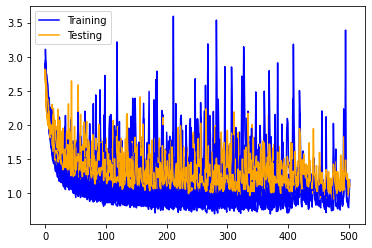

In [5]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

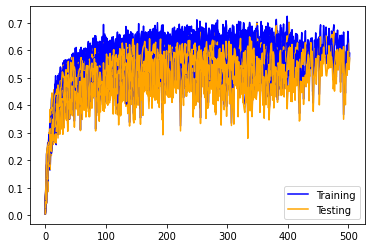

In [6]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

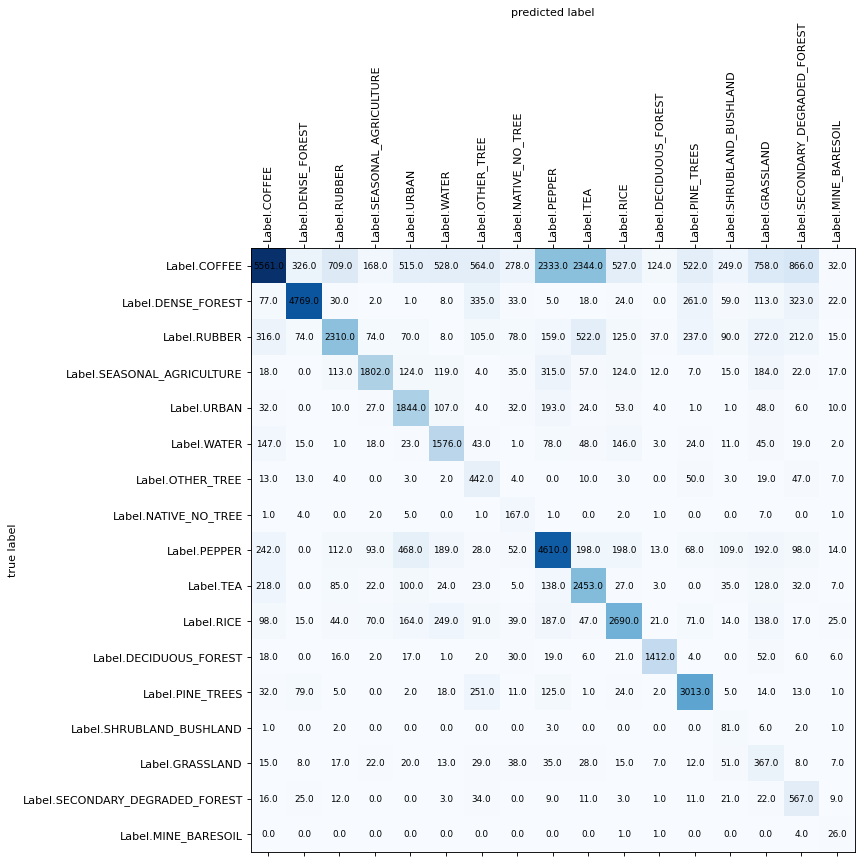

In [7]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrix, labels)

In [8]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.81719324 0.89508258 0.66570605 0.78279757 0.54946365 0.55395431
 0.22597137 0.20797011 0.56151035 0.42535114 0.67537032 0.86045094
 0.70380752 0.10887097 0.1551797  0.2528992  0.12871287]
Mean precision:  0.504134817440931

Recalls:  [0.33900268 0.784375   0.49107143 0.60714286 0.76961603 0.71636364
 0.71290323 0.86979167 0.68970676 0.74333333 0.6758794  0.87593052
 0.83787542 0.84375    0.53034682 0.76209677 0.8125    ]
Mean recall:  0.7095109146762099

F-Score:  [0.47921065 0.83607994 0.56520675 0.68387097 0.64116829 0.62477701
 0.3431677  0.33567839 0.61904122 0.54108305 0.67562476 0.86812173
 0.76501206 0.19285714 0.24010468 0.37977227 0.22222222]
Mean f-score:  0.5301764030080907
